# Tufts Turf HOG demo 

Experimenting with the Tufts Turf campus scene (generated by colmap)

Attempting to match satellite image with this data 

In [1]:
import numpy as np
import cv2
from skimage import *
from skimage import feature
import math
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog

%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
# Import images 

# COLMAP reference image 
im_ref = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/TTurf_ref_map.png')

# Satellite image 
sat_im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/satV1_TTurf.png')

ref_gray = cv2.cvtColor(im_ref, cv2.COLOR_RGB2GRAY)
ref_color = cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)
im_gray = cv2.cvtColor(sat_im, cv2.COLOR_RGB2GRAY)
im_color = cv2.cvtColor(sat_im, cv2.COLOR_BGR2RGB)


ref_hog, refim_hog = feature.hog(ref_gray, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), visualize=True)
sat_hog, satim_hog = feature.hog(im_gray, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), visualize=True)


## RESIZE IMAGES TO MATCH 

In [5]:
print(im_ref.shape)
# Specify the desired dimensions to crop specific pictures 
width_s = 860
width_e = width_s + 100 # desired width in pixels
height_s = 400
height_e = height_s + 200  # desired height in pixels

# Crop the image 
im_crop = im_ref[height_s:height_e, width_s:width_e] #, height_s:height_e]

cv2.imshow('Resized Image', im_crop)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1018, 1244, 3)


THE WINDOW SHOULD BE AT AROUND 860 width, 400 height

Resizing satellite image to match 200x100 size (heighxwidth)

In [9]:
# RESIZE the satellite image to 100x200
width_n = 100
height_n = 200
new_dim = (width_n, height_n)
im_sat = cv2.resize(sat_im, new_dim)
im_color = cv2.cvtColor(im_sat, cv2.COLOR_BGR2RGB)

print(im_sat.shape)

(200, 100, 3)


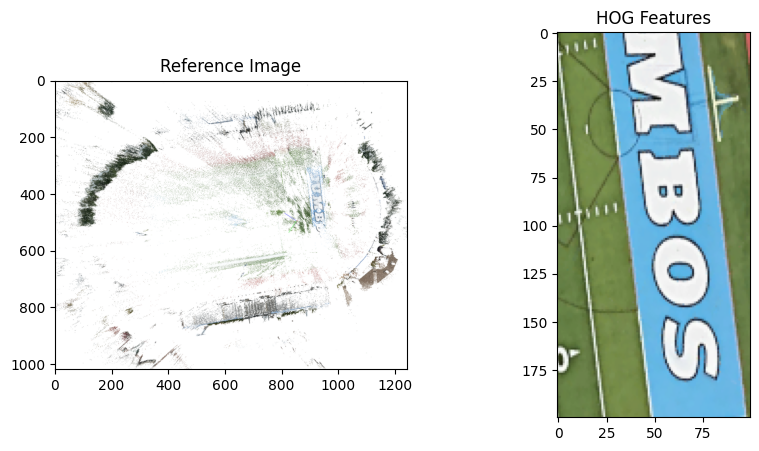

In [10]:
# Visualize the original reference image and the HOG features
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Reference Image")
plt.imshow(ref_color, cmap='gray')
# plt.imshow(im_gray, cmap='gray')


plt.subplot(1, 2, 2)#
plt.title("HOG Features")
# plt.imshow(refim_hog, cmap='gray')  # Use the visualization of HOG features
# plt.imshow(satim_hog, cmap='gray')  # Use the visualization of HOG features
plt.imshow(im_color, cmap='gray')
plt.show()


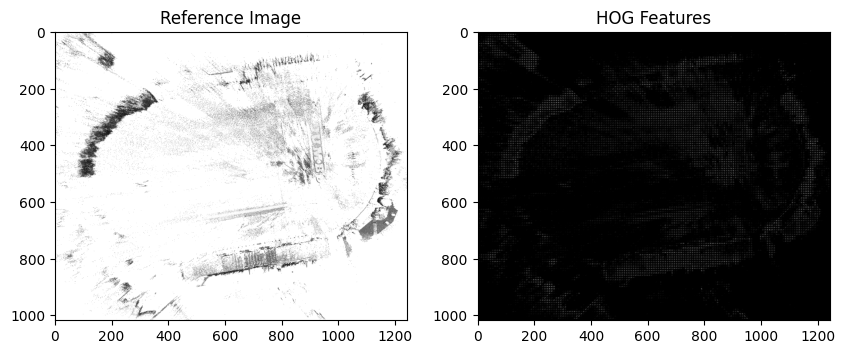

In [11]:
# Visualize the original reference image and the HOG features
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Reference Image")
plt.imshow(ref_gray, cmap='gray')
# plt.imshow(im_gray, cmap='gray')


plt.subplot(1, 2, 2)
plt.title("HOG Features")
plt.imshow(refim_hog, cmap='gray')  # Use the visualization of HOG features
# plt.imshow(satim_hog, cmap='gray')  # Use the visualization of HOG features
plt.show()


In [12]:
# SLIDING WINDOW APPROACH 

def sliding_window(image, step_size, window_size):
    """
    Generator to slide a window across the image
    Inputs: image, step size, window size
    Outputs: coordinates(x,y) for the top-left corner of each window
    """
    for y in range(0, image.shape[0] - window_size[1], step_size): # NOTE: image shape reads height x width, idk why
        for x in range(0, image.shape[1] - window_size[0], step_size):
            # print(x,y)
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def compute_hog(image):
    """Compute HOG features and return the features and visualization."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features, hog_image = feature.hog(gray_image, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2), visualize=True)
    return hog_features, hog_image

(100, 200)
16.84393757072966 0 0
16.925955303790804 86 0
16.86792967657175 172 0
16.578588560612626 258 0
17.494899123130338 344 0
17.21616267212554 430 0
17.0105760472973 516 0
16.59927900525305 602 0
16.478196337297245 688 0
16.64693882646531 774 0
17.321224457502336 860 0
17.72113002464768 946 0
17.62543661176227 1032 0
16.877102237431206 1118 0
18.03032070690697 0 86
17.333705857727665 86 86
17.05815299602483 172 86
16.657748361139575 258 86
18.027716853750537 344 86
17.564733550540755 430 86
17.002405475694694 516 86
17.307832147986055 602 86
15.855066448133572 688 86
15.950824859065564 774 86
17.708519927290396 860 86
18.02107153965697 946 86
17.599898994415295 1032 86
17.32542666791656 1118 86
18.33444462470127 0 172
17.350852308951747 86 172
16.915391243281903 172 172
17.323591433620596 258 172
17.615298148885856 344 172
17.06214403037037 430 172
16.526068254449918 516 172
16.417357036066754 602 172
15.383461941408283 688 172
15.346463267010197 774 172
16.535658840987722 860 17

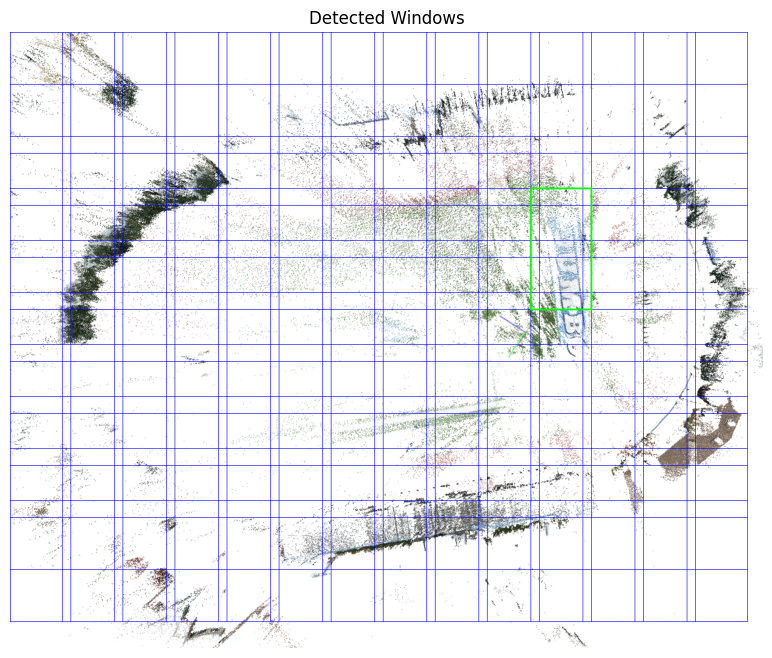

In [16]:
# Get dimensions for sliding window
# Based on SATELLITE IMAGE
window_size = im_sat.shape[1], im_sat.shape[0]  # (width, height)
print(window_size)

# Compute HOG features for the satellite image
sat_hog, sat_hogim = compute_hog(im_sat)

# Define step size for the sliding window
step_size = 86  # Because we want 860***
best_match = None
best_distance = float('inf')
best_location = (0, 0)
# List to hold matching windows
matching_windows = []

# Create a duplicate image to plot on (DONT USE THE SAME IMAGE FOR A HOG)
im_plot = im_ref.copy()

# Scan the larger image with the sliding window
for (x, y, window) in sliding_window(im_ref, step_size, window_size):
    if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        print("SIZE ISSUE")
        continue  
    # Compute HOG features for the current window
    window_hog, window_hogim = compute_hog(window)
    
    # # Visualize the original reference image and the HOG features
    # plt.figure(figsize=(10, 5))
    # plt.title("Reference Image")
    # plt.imshow(window_hogim, cmap='gray')
    # plt.show()
    #  # Visualize the original reference image and the HOG features
    # plt.figure(figsize=(10, 5))
    # plt.title("Reference Image")
    # plt.imshow(reg_hogim, cmap='gray')
    # plt.show()
    
    distance = euclidean(sat_hog, window_hog)
    print(distance, x,y)

    # Update the best match if the current window is more similar
    if distance < best_distance:
        best_distance = distance
        best_match = window
        best_location = (x, y)

    # OPTIONALLY, Draw a rectangle for the current window (red)
    cv2.rectangle(im_plot, 
                  (x, y), 
                  (x + window_size[0], y + window_size[1]), 
                  (255, 0, 0), 1)  # Red rectangle with thickness 1 for all windows
    # It will come out blue because of the BGR to RGB conversion 
    
    
    # # Compare HOG features DIFFERENT VERSION ????
    # similarity = np.dot(ref_hog, window_hog) / (np.linalg.norm(ref_hog) * np.linalg.norm(window_hog))
    
    # # Define a threshold for similarity
    # threshold = 0.5  # Adjust based on your requirements
    # if similarity > threshold:
    #     matching_windows.append((x, y, window))

print(f"Best match found at location: {best_location} with distance: {best_distance}")

# Visualize best location 
cv2.rectangle(im_plot, (best_location[0], best_location[1]), 
              (best_location[0] + window_size[0], best_location[1] + window_size[1]), 
              (0, 255, 0), 2)

# Show the resulting image with detected windows
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(im_plot, cv2.COLOR_RGB2BGR))
plt.title('Detected Windows')
plt.axis('off')
plt.show()

In [ ]:
# Visualize the best match
# First, reset the image
im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/TTurf_ref_map.png') 
plt.figure(figsize=(15, 8))
cv2.rectangle(im, (best_location[0], best_location[1]), 
              (best_location[0] + window_size[0], best_location[1] + window_size[1]), 
              (0, 255, 0), 2)



# plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
plt.title("Best Match Found")
plt.show()

In [ ]:
# plt.subplot(2, 1, 1)
plt.title("HOG Features")
# plt.imshow(refim_hog, cmap='gray')  # Use the visualization of HOG features
plt.imshow(refim_hog, cmap='gray')  # Use the visualization of HOG features
plt.show()